In [59]:
import os
os.chdir("../input")

In [62]:
import time

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [63]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, use_batchnorm=True, use_dropout=True):
        super(NN, self).__init__()

        layers = []
        cur_size = input_size

        for size in hidden_layers:
            layers.append(nn.Linear(cur_size, size))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(size))
            layers.append(nn.Tanh())
            if use_dropout:
                layers.append(nn.Dropout(0.5))
            cur_size = size
        
        layers.append(nn.Linear(size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, X):
        return self.model(X)
    
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [64]:
df = pd.read_csv("transformed_heart.csv")

In [65]:
X = df.drop("output", axis=1)
y = df["output"]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [67]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [69]:
model = NN(X.shape[1], [32, 16, 8], 1)

In [70]:
num_epochs = 1000
learning_rate = 0.01

In [71]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

In [72]:
%time

train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

model.train()
for epoch in range(num_epochs):
    y_pred = model(X_train).squeeze(-1)
    train_loss = criterion(torch.sigmoid(y_pred), y_train)
    train_losses.append(train_loss.item())
    
    train_acc = binary_acc(y_pred, y_train)
    train_accuracies.append(train_acc.item())

    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test).squeeze(-1)
        test_loss = criterion(torch.sigmoid(y_test_pred), y_test)
        test_losses.append(test_loss.item())
        
        test_acc = binary_acc(y_test_pred, y_test)
        test_accuracies.append(test_acc.item())
    model.train()

    print(f"Epoch {epoch + 1:03}: | Train Loss: {train_loss.item():.4f} | Test Loss: {test_loss.item():.4f} "
        f"| Train Acc: {train_acc.item():.2f}% | Test Acc: {test_acc.item():.2f}%")

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 4.77 μs
Epoch 001: | Train Loss: 0.6806 | Test Loss: 0.6636 | Train Acc: 57.00% | Test Acc: 69.00%
Epoch 002: | Train Loss: 0.6575 | Test Loss: 0.6475 | Train Acc: 62.00% | Test Acc: 75.00%
Epoch 003: | Train Loss: 0.6473 | Test Loss: 0.6295 | Train Acc: 63.00% | Test Acc: 75.00%
Epoch 004: | Train Loss: 0.6120 | Test Loss: 0.6118 | Train Acc: 71.00% | Test Acc: 79.00%
Epoch 005: | Train Loss: 0.5929 | Test Loss: 0.5937 | Train Acc: 69.00% | Test Acc: 79.00%
Epoch 006: | Train Loss: 0.6181 | Test Loss: 0.5788 | Train Acc: 67.00% | Test Acc: 82.00%
Epoch 007: | Train Loss: 0.5819 | Test Loss: 0.5633 | Train Acc: 74.00% | Test Acc: 82.00%
Epoch 008: | Train Loss: 0.5808 | Test Loss: 0.5488 | Train Acc: 69.00% | Test Acc: 84.00%
Epoch 009: | Train Loss: 0.5338 | Test Loss: 0.5356 | Train Acc: 74.00% | Test Acc: 84.00%
Epoch 010: | Train Loss: 0.5538 | Test Loss: 0.5235 | Train Acc: 72.00% | Test Acc: 84.00%
Epoch 011: | Train Los

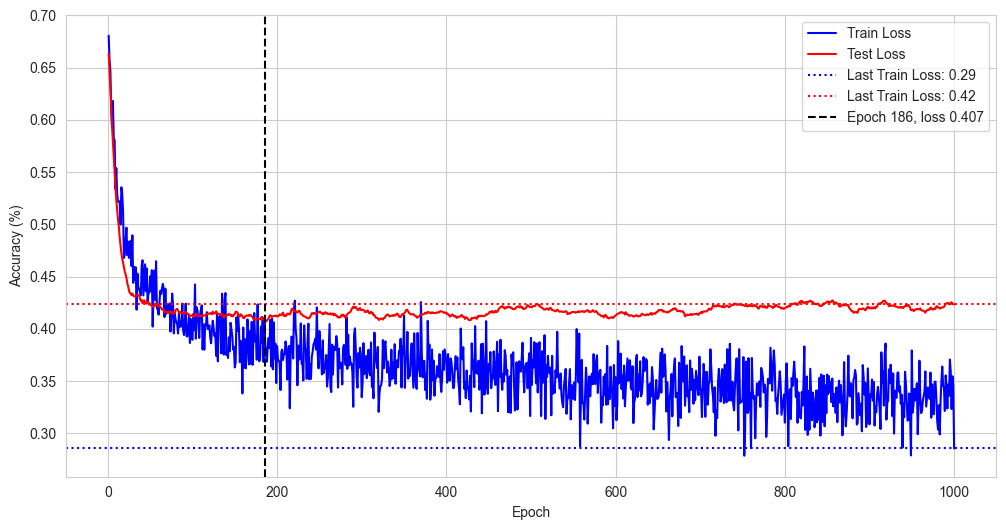

In [78]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, num_epochs+1), y=train_losses,label="Train Loss", color="blue")
sns.lineplot(x=range(1, num_epochs+1), y=test_losses,label="Test Loss", color="red")

plt.axhline(y=train_losses[-1], color='blue', linestyle=':', label=f'Last Train Loss: {train_losses[-1]:.2f}')
plt.axhline(y=test_losses[-1], color='red', linestyle=':', label=f'Last Train Loss: {test_losses[-1]:.2f}')

plt.axvline(x=np.argmin(test_losses), color="black", linestyle="--", label=f"Epoch {np.argmin(test_losses)}, loss {min(test_losses):.3f}")

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

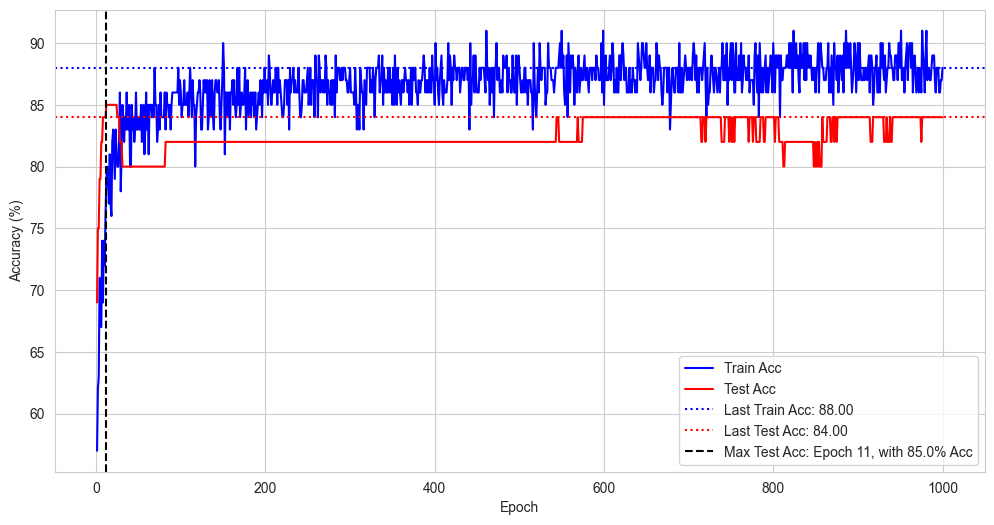

In [80]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, num_epochs+1), y=train_accuracies,label="Train Acc", color="blue")
sns.lineplot(x=range(1, num_epochs+1), y=test_accuracies,label="Test Acc", color="red")

plt.axhline(y=train_accuracies[-1], color='blue', linestyle=':', label=f'Last Train Acc: {train_accuracies[-1]:.2f}')
plt.axhline(y=test_accuracies[-1], color='red', linestyle=':', label=f'Last Test Acc: {test_accuracies[-1]:.2f}')

plt.axvline(x=np.argmax(test_accuracies), color="black", linestyle="--", label=f"Max Test Acc: Epoch {np.argmax(test_accuracies)}, with {max(test_accuracies)}% Acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()